In [1]:
import numpy as np
import pandas as pd
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from matplotlib import pyplot
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline

In [2]:
# tokenizing the text data and add padding
def tokenize(input_df):
    token = Tokenizer(num_words=5000)
    token.fit_on_texts(input_df['text'].values)
    tokenized_data = token.texts_to_sequences(input_df['text'].values)
    pad_data = pad_sequences(tokenized_data, maxlen=130)
    unique = token.word_index
    print('Found %s unique tokens.' % len(unique))
    return pad_data, unique

In [3]:
# glove embedding
def glove_embed(word_index):
    embeddings_index = {}
    file = open('glove.6B.100d.txt', 'r', encoding='utf-8')
    for line in file:
        values = line.split(' ')
        word = values[0]
        coefficients = np.asarray([float(val) for val in values[1:]])
        embeddings_index[word] = coefficients
    file.close()

    embedding_matrix = np.zeros((len(word_index) + 1, 100))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix


# lstm model
def lstm_impl(train_data, test_data, train_label, test_label):
    model = Sequential()
    model.add(Embedding(5000, 130, input_length=X_train.shape[1]))
    model.add(SpatialDropout1D(0.7))
    model.add(LSTM(64, dropout=0.7))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',
                  metrics=['accuracy'])
    print(model.summary())
    history = model.fit(train_data, train_label, epochs=20, batch_size=32,
                        validation_data=(test_data, test_label),
                        callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
    print(history)

    loss, accuracy = model.evaluate(test_data, test_label)
    print("\naccuracy", accuracy)
    plot(history)
    return accuracy


# lstm model with glove
def lstm_impl_with_glove(train_data, test_data, train_label, test_label, word_index):
    embedding_matrix = glove_embed(word_index)
    model = Sequential()
    model.add(Embedding(len(word_index) + 1, 100, weights=[embedding_matrix], input_length=130, trainable=False))
    model.add(LSTM(64, dropout=0.3))
    model.add(Dense(3, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    history = model.fit(train_data, train_label, epochs=20, batch_size=32,
                        validation_data=(test_data, test_label),
                        callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
    print(history)

    score, accuracy = model.evaluate(test_data, test_label)
    print('\naccuracy', accuracy)
    plot(history)
    return accuracy

In [4]:
# random forest classifier
def rf_classification(train_data, test_data, train_sentiment, test_sentiment):
    print('Starting Random Forest classification')
    pipe = make_pipeline(RandomForestClassifier(n_estimators=50, criterion='entropy', random_state=0))
    pipe.fit(train_data, train_sentiment)
    y_hat = pipe.predict(test_data)
    accuracy = accuracy_score(test_sentiment, y_hat)
    print('Random Forest Accuracy', accuracy)
    return accuracy

In [5]:
# support vector machine classifier
def svm_classification(train_data, test_data, train_sentiment, test_sentiment):
    print('Starting SVM classification')
    clf = OneVsRestClassifier(svm.SVC(gamma=0.01, C=100., probability=True, class_weight='balanced', kernel='linear'))
    clf.fit(train_data, train_sentiment)
    accuracy = clf.score(test_data, test_sentiment)
    print('Support Vector Machine Accuracy', accuracy)
    return accuracy

In [6]:
# plot for epoch accuracy
def plot(model_history):
    pyplot.plot(model_history.history['accuracy'], label='train')
    pyplot.plot(model_history.history['val_accuracy'], label='test')
    pyplot.legend()
    pyplot.show()

In [7]:
import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# find the category of word for further lemmatization
def word_type(word):
    if word.startswith('J'):
        return wordnet.ADJ
    elif word.startswith('V'):
        return wordnet.VERB
    elif word.startswith('N'):
        return wordnet.NOUN
    elif word.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


# lemmatize the text into base words
def text_lemmatizer(word):
    # initialize the word lemmatizer
    lemmatizer = WordNetLemmatizer().lemmatize
    word = word_tokenize(str(word))
    word_pos = pos_tag(word)
    lemmatized_words = [lemmatizer(w[0], word_type(w[1])) for w in word_pos]
    return ' '.join(lemmatized_words)


# clean the tweet data
# remove @mention of tweeter handles
# remove '#' tags
# remove retweets
# remove hyperlink
# remove numbers in tweet
# remove extra white spaces
# lemmatize the words
# rejoin the clean words in string format again
def cleanText(tweet):
    word_list = tweet.lower().split()
    stop_list = set(stopwords.words("english"))
    important_words = [w for w in word_list if not w in stop_list]

    clean_word_list = []
    for word in important_words:
        word = re.sub('@[A-Za-z0–9]+', '', word)  # Removing @mentions
        word = re.sub('#', '', word)  # Removing '#' hash tag
        word = re.sub('RT[\s]+', '', word)  # Removing RT
        word = re.sub('https?:\/\/\S+', '', word)  # Removing hyperlink
        word = re.sub('\d+', '', word)  # remove number
        word = re.sub(r'[^a-zA-Z]', '', word)
        word = re.sub(r'\s+', ' ', word)  # remove white space
        word = text_lemmatizer(word)
        clean_word_list.append(word)

    return " ".join(clean_word_list)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


(14402, 2)
                                                    text  ... label
11067                  problem thing work airport thanks  ...     2
4279     ua roll improvement too think hop theyll cat...  ...     1
2364    board movement  minwow experience keep get ba...  ...     0
4040            possible upfare p segment gpu waitlisted  ...     1
6164    stay chicago overnight meet bag there hope st...  ...     0

[5 rows x 3 columns]
Starting Random Forest classification
Random Forest Accuracy 0.7809788267962513
Starting SVM classification
Support Vector Machine Accuracy 0.7618882332523429
(14402, 3)
[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
Found 10615 unique tokens.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output

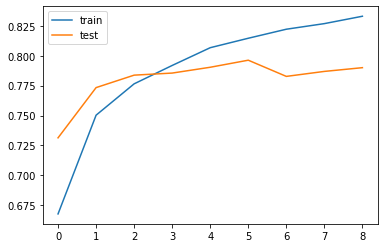

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 130, 100)          1061600   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 1,104,035
Trainable params: 42,435
Non-trainable params: 1,061,600
_________________________________________________________________
None
Epoch 1/20
361/361 [==============================] - 27s 75ms/step - loss: 0.4335 - accuracy: 0.7053 - val_loss: 0.3793 - val_accuracy: 0.7504
Epoch 2/20
361/361 [==============================] - 29s 81ms/step - loss: 0.3739 - accuracy: 0.7517 - val_loss: 0.3552 - val_accuracy: 0.7726
Epoch 3/20
361/361 [==============================] - 29s 79ms/step - loss: 

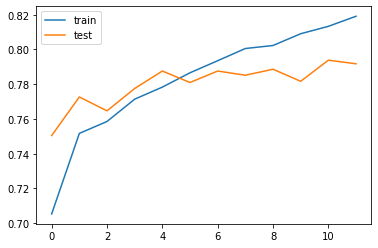


RF Accuracy 0.7809788267962513
SVM Accuracy 0.7618882332523429
LSTM Accuracy 0.7900034785270691
LSTM with Glove Accuracy 0.7917389869689941


In [8]:
# main method
if __name__ == '__main__':
    data = pd.read_csv('Tweets.csv')
    data = data.reindex(np.random.permutation(data.index))
    # data = data[:500]
    data = data[data['airline_sentiment_confidence'] > 0.6]
    data = data[['text', 'airline_sentiment']]
    print(data.shape)

    # clean all the tweets for further processing
    data['text'] = data['text'].apply(lambda x: cleanText(x))
    # change the resulting classes from words to integers for ease of classification
    data['label'] = data['airline_sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})
    print(data.head())

    # vectorization
    count_vec = CountVectorizer(ngram_range=(1, 2))
    vect_data = count_vec.fit_transform(data.text)
    train_data, test_data, train_sentiment, test_sentiment = train_test_split(vect_data, data['label'], test_size=0.2,
                                                                              random_state=0)
    train_data = train_data[:, 1:]
    test_data = test_data[:, 1:]

    # random forest classifier
    rf_acc = rf_classification(train_data, test_data, train_sentiment, test_sentiment)
    # support vector classifier
    svm_acc = svm_classification(train_data, test_data, train_sentiment, test_sentiment)

    # convert sentiment label to class matrix
    labels = to_categorical(data['label'], num_classes=3)
    print(labels.shape)
    print(labels[:20])

    # tokenizing and padding text data
    padded_data, vocab = tokenize(data)
    # splitting train and test data
    X_train, X_test, y_train, y_test = train_test_split(padded_data, labels, test_size=0.2, random_state=42,
                                                        shuffle=True)
    # lstm classification
    lstm_acc = lstm_impl(X_train, X_test, y_train, y_test)
    # lstm classification with glove embedding
    glove_acc = lstm_impl_with_glove(X_train, X_test, y_train, y_test, vocab)

    print('\nRF Accuracy', rf_acc)
    print('SVM Accuracy', svm_acc)
    print('LSTM Accuracy', lstm_acc)
    print('LSTM with Glove Accuracy', glove_acc)